In [1]:
# All imports
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
from IPython import display
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.metrics import f1_score
import joblib
from skimage.feature import hog
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, Normalizer
import mahotas
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer


In [2]:
# Load ML-Ready data
df = pd.read_csv("DataReady.csv",delimiter="|", keep_default_na=False) #empty cells = empty strings instead of Nan

In [6]:
df.head()

,Color,Name,URL,name,text,categorical
0,White,Plains,https://c1.scryfall.com/file/scryfall-cards/la...,plains,,plains land 0
1,Blue,Island,https://c1.scryfall.com/file/scryfall-cards/la...,island,,island land 0
2,Black,Swamp,https://c1.scryfall.com/file/scryfall-cards/la...,swamp,,swamp land 0
3,Red,Mountain,https://c1.scryfall.com/file/scryfall-cards/la...,mountain,,mountain land 0
4,Green,Forest,https://c1.scryfall.com/file/scryfall-cards/la...,forest,,forest land 0


In [3]:
# Load image pixel data
pixel_data = joblib.load("ImageDataCrop.pkl")
df_pixel = pd.DataFrame.from_dict(pixel_data)

In [8]:
df_pixel.head()

,Name,ImageDataCrop
0,Plains,"[[[135, 127, 120], [141, 135, 130], [99, 84, 7..."
1,Island,"[[[50, 68, 97], [55, 73, 105], [88, 79, 82], [..."
2,Swamp,"[[[36, 31, 26], [39, 35, 33], [85, 74, 68], [1..."
3,Mountain,"[[[102, 44, 30], [138, 60, 42], [92, 73, 65], ..."
4,Forest,"[[[48, 55, 40], [53, 68, 42], [75, 62, 61], [1..."


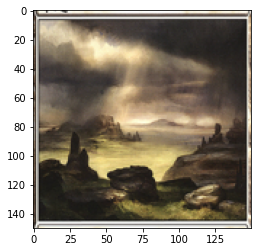

In [9]:
plt.imshow(df_pixel['ImageDataCrop'][0])

In [10]:
# Confirm we have as many images as we have cards
print(len(df),len(df_pixel))

20197 20197


In [4]:
# Create a df with all the information we'll need for ML
df = pd.merge(df,df_pixel,on=["Name"])

In [12]:
df.head()

,Color,Name,URL,name,text,categorical,ImageDataCrop
0,White,Plains,https://c1.scryfall.com/file/scryfall-cards/la...,plains,,plains land 0,"[[[135, 127, 120], [141, 135, 130], [99, 84, 7..."
1,Blue,Island,https://c1.scryfall.com/file/scryfall-cards/la...,island,,island land 0,"[[[50, 68, 97], [55, 73, 105], [88, 79, 82], [..."
2,Black,Swamp,https://c1.scryfall.com/file/scryfall-cards/la...,swamp,,swamp land 0,"[[[36, 31, 26], [39, 35, 33], [85, 74, 68], [1..."
3,Red,Mountain,https://c1.scryfall.com/file/scryfall-cards/la...,mountain,,mountain land 0,"[[[102, 44, 30], [138, 60, 42], [92, 73, 65], ..."
4,Green,Forest,https://c1.scryfall.com/file/scryfall-cards/la...,forest,,forest land 0,"[[[48, 55, 40], [53, 68, 42], [75, 62, 61], [1..."


In [5]:
df[df['ImageDataCrop'].isnull()]

,Color,Name,URL,name,text,categorical,ImageDataCrop


Feature/Label split

In [5]:
# features
X = df[['Name','URL','name','text','categorical','ImageDataCrop']] #dataframe
X.head()

,Name,URL,name,text,categorical,ImageDataCrop
0,Plains,https://c1.scryfall.com/file/scryfall-cards/la...,plains,,plains land 0,"[[[135, 127, 120], [141, 135, 130], [99, 84, 7..."
1,Island,https://c1.scryfall.com/file/scryfall-cards/la...,island,,island land 0,"[[[50, 68, 97], [55, 73, 105], [88, 79, 82], [..."
2,Swamp,https://c1.scryfall.com/file/scryfall-cards/la...,swamp,,swamp land 0,"[[[36, 31, 26], [39, 35, 33], [85, 74, 68], [1..."
3,Mountain,https://c1.scryfall.com/file/scryfall-cards/la...,mountain,,mountain land 0,"[[[102, 44, 30], [138, 60, 42], [92, 73, 65], ..."
4,Forest,https://c1.scryfall.com/file/scryfall-cards/la...,forest,,forest land 0,"[[[48, 55, 40], [53, 68, 42], [75, 62, 61], [1..."


In [6]:
# labels
Y = df['Color'] #series
Y

0            White
1             Blue
2            Black
3              Red
4            Green
           ...    
20192    Colorless
20193    Colorless
20194    Colorless
20195         Blue
20196    Colorless
Name: Color, Length: 20197, dtype: object

Train/Test split

In [7]:
# split data
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,shuffle=True,random_state=42,)

In [21]:
print(len(x_train),len(x_test))

16157 4040


In [8]:
def split_txt_img(x):
    '''
    Splits a dataframe into image-only data and text-only data.

            Parameters:
                    x (pandas dataframe): Data frame with image and text data.

            Returns:
                    X_txt (numpy.ndarray): Numpy array with text data from 'name','text' and 'categorical' columns.
                    X_img (numpy.ndarray): Numpy array with image data from 'ImageDataCrop' columns.
    '''
    X_name = np.array(x['name'])
    X_text = np.array(x['text'])
    X_cat = np.array(x['categorical'])

    X_txt = np.stack((X_name, X_text, X_cat),axis=1)
    X_img = np.array(x['ImageDataCrop'])

    return X_txt, X_img

# For each train/test set, divide the data into text/image:
X_txt_train, X_img_train = split_txt_img(x_train)
X_txt_test, X_img_test = split_txt_img(x_test)

In [59]:
X_txt_test[0]

array(['wrecking ogre',
       'double strikebloodrush —  discard wrecking ogre target attacking creature gets +3/+3 gains double strike end turn',
       'ogre warrior creature bloodrush double strike 3 3 5'],
      dtype=object)

In [60]:
X_img_test[0]

array([[[122,  36,  26],
        [136,  45,  32],
        [ 95,  75,  71],
        ...,
        [249, 197, 159],
        [190, 159, 127],
        [153,  52,  35]],

       [[ 76,  28,  25],
        [174,  49,  31],
        [ 73,  57,  50],
        ...,
        [245, 194, 159],
        [150, 113,  89],
        [187,  53,  34]],

       [[ 43,  18,  16],
        [185,  50,  38],
        [ 78,  43,  36],
        ...,
        [196, 157, 129],
        [120,  74,  58],
        [211,  58,  39]],

       ...,

       [[182, 122, 105],
        [108,  54,  52],
        [229,  56,  42],
        ...,
        [225,  58,  41],
        [242,  59,  45],
        [239, 127, 104]],

       [[108,  54,  46],
        [155,  46,  35],
        [250,  54,  38],
        ...,
        [122,  68,  54],
        [238,  53,  37],
        [235,  76,  51]],

       [[ 78,  40,  37],
        [191,  50,  37],
        [204,  47,  32],
        ...,
        [145, 136, 122],
        [201,  51,  36],
        [243,  54,  43]]

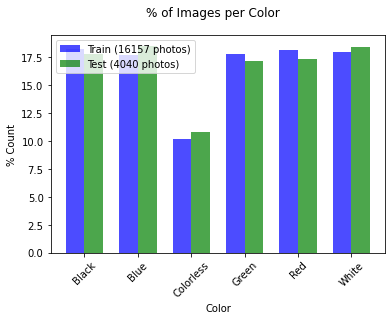

In [61]:
# Check if data split is well distributed
def plot_TestTrain(y,n,c):
    '''
    Plots a bar graph with the percentual count of Images/Cards in each color, in both the testing and training sets.

            Parameters:
                    y (pandas series): Series with label data for the test/training data sets.
                    n (int): Number that controls the placement of the bars in the plot.
                    c (str): Bar color.
    '''
    # train
    unique, counts = np.unique(y, return_counts=True) #get unique labels and counts
    sorted_index = np.argsort(unique) #create array of idx from unique
    unique = unique[sorted_index]
    counts = 100*counts[sorted_index]/len(y) # %counts; sorted index allows us to use an array of idx as an idx to an array (to skip for loop?)

    ylabel_text = '% Count'
    xticks = np.arange(len(unique))

    plt.bar(xticks + n*0.35, counts, align='center', alpha=.7, width=0.35, color = c) #n*0.35 is so that the bars are centered and symetrical around xticks
    plt.xticks(xticks, unique, rotation=45) #put xtick labels in the right place
    plt.xlabel('Color')
    plt.ylabel(ylabel_text)

# Plot + legend
plot_TestTrain(y_train,-0.5,'b')
plot_TestTrain(y_test,0.5,'g')
plt.suptitle('% of Images per Color')
plt.legend(["Train ("+str(len(y_train))+" photos)", "Test ("+str(len(y_test))+" photos)"])

Model 1 - Text Data

In [16]:
X_txt_train

array([['tower murmurs', '  target player mills eight cards',
        'artifact mill 4'],
       ['dreadhorde invasion',
        'beginning upkeep lose 1 life amass 1 put +1/+1 counter army control control one create 0/0 black zombie army creature token firstwhenever zombie token control power 6 greater attacks gains lifelink end turn',
        'enchantment amass 2'],
       ['luminate primordial',
        'vigilanceluminate primordial enters battlefield opponent exile one target creature player controls player gains life equal power',
        'avatar creature vigilance 4 7 7'],
       ...,
       ['frilled sea serpent', ' frilled sea serpent blocked turn',
        'serpent creature 4 6 6'],
       ['inkmoth nexus',
        ' inkmoth nexus becomes 1/1 phyrexian blinkmoth artifact creature flying infect end turn still land deals damage creatures form -1/-1 counters players form poison counters',
        'land 0'],
       ['farbog explorer',
        'swampwalk creature blocked long defen

In [12]:
# FUNCTION: Text feature extraction
def extract_text_features(idx,x_train,x_test):
    '''
    Extracts the text features from a dataframe column.

            Parameters:
                    idx (int): Represents the index of the numpy array data that we want to extract features from (0:names, 1:text, 2:categorical).
                    x_train (numpy.ndarray): Numpy array with train data.
                    x_test (numpy.ndarray): Numpy array with test data.

            Returns:
                    x_train_features (sparse matrix): Sparse matrix with the feature vectors of the train text data.
                    x_test_features (sparse matrix): Sparse matrix with the feature vectors of the test text data.
    '''    
    # train model with train data only
    train = list(x_train[:,idx]) 
    vectorizer = TfidfVectorizer(min_df = 5, max_df = 0.5, sublinear_tf = True, ngram_range = (1, 1))
    vectorizer.fit(train)
    
    # apply model to train/test data
    x_train_features = vectorizer.transform(x_train[:,idx])
    x_test_features = vectorizer.transform(x_test[:,idx])
    
    # return feature vector for train/test data
    return (x_train_features,x_test_features)

# apply to names column (idx 0 of X_txt_train/train)
(x_train_name,x_test_name) = extract_text_features(0,X_txt_train,X_txt_test)

# apply to text column (idx 1 of X_txt_train/train)
(x_train_text,x_test_text) = extract_text_features(1,X_txt_train,X_txt_test)

# apply to categorical column (idx 2 of X_txt_train/train)
(x_train_cat,x_test_cat) = extract_text_features(2,X_txt_train,X_txt_test)

In [17]:
# stack the feature vectors (ML model only allows 1 input per card, so we need to stack all the feature vectors inside a big sparse matrix)
x_train_features_m1 = hstack((x_train_name, x_train_text, x_train_cat))
x_test_features_m1 = hstack((x_test_name, x_test_text, x_test_cat))

In [13]:
# find best classifier for model 1
models = []
models.append(('LogR', LogisticRegression(max_iter=2000))) #LinearRegression for dummy/categorical Ys
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=42)))
models.append(('RF', RandomForestClassifier(n_estimators=100, random_state=42)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=42)))
models.append(('SGD',  SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)))

results = []
names   = []

x_train_features_m1_array = x_train_features_m1.toarray() #sparse>dense

# 10-fold cross validation (check accuracy for all models)
for name, model in models:
    kfold = KFold(n_splits=5, random_state=42,shuffle=True)
    cv_results = cross_val_score(model, x_train_features_m1_array, y_train, cv=kfold, scoring="accuracy")
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LogR: 0.762022 (0.008536)
LDA: 0.708546 (0.012761)
KNN: 0.579501 (0.005066)
CART: 0.608281 (0.008263)
RF: 0.712322 (0.010474)
NB: 0.508139 (0.006952)
SVM: 0.745620 (0.008382)
SGD: 0.758494 (0.009012)


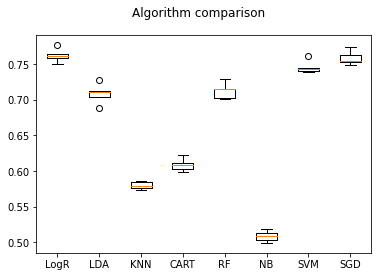

In [14]:
# Algorithm comparison plot
fig = plt.figure()
fig.suptitle('Algorithm comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [51]:
#Grid Search LogR
from sklearn.model_selection import GridSearchCV
parameter_grid = {'C':[0.1,1,10,100,1000]}
grid = GridSearchCV(LogisticRegression(max_iter=3000),parameter_grid,verbose=3)
grid.fit(x_train_features_m1, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END .............................C=0.1;, score=0.724 total time=   0.4s
[CV 2/5] END .............................C=0.1;, score=0.742 total time=   0.2s
[CV 3/5] END .............................C=0.1;, score=0.722 total time=   0.2s
[CV 4/5] END .............................C=0.1;, score=0.707 total time=   0.2s
[CV 5/5] END .............................C=0.1;, score=0.717 total time=   0.2s
[CV 1/5] END ...............................C=1;, score=0.761 total time=   0.6s
[CV 2/5] END ...............................C=1;, score=0.776 total time=   0.6s
[CV 3/5] END ...............................C=1;, score=0.767 total time=   0.6s
[CV 4/5] END ...............................C=1;, score=0.748 total time=   0.7s
[CV 5/5] END ...............................C=1;, score=0.751 total time=   0.7s
[CV 1/5] END ..............................C=10;, score=0.741 total time=   1.6s
[CV 2/5] END ..............................C=10;,

GridSearchCV(estimator=LogisticRegression(max_iter=3000),
             param_grid={'C': [0.1, 1, 10, 100, 1000]}, verbose=3)

In [52]:
grid.best_estimator_

LogisticRegression(C=1, max_iter=3000)

In [21]:
# Model 1: Logistic Regression (text features)
Model_1  = LogisticRegression(max_iter=3000,C=1)
Model_1.fit(x_train_features_m1, y_train)
predictions_1 = Model_1.predict(x_test_features_m1)
predictions_proba_1 = Model_1.predict_proba(x_test_features_m1)

print('Percentage correct: ', 100*np.sum(predictions_1 == y_test)/len(y_test))
F1_1 = f1_score(y_test, predictions_1,average='weighted')
print('F1 Score: ',F1_1)

Percentage correct:  76.73267326732673
F1 Score:  0.7662793472551213


Model 2 - Image Data

In [ ]:
# We can transform our entire image data set using transformers. 
# These are objects that take in the array of data, transform each item and return the resulting data.

In [22]:
# Transformer RGB >> grayscale
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    '''
    Converts an array of RGB images to grayscale.
    '''  
    def __init__(self):
        pass
 
    def fit(self, x, y=None):
        """returns itself"""
        return self
 
    def transform(self, x, y=None):
        """performs the transformation and returns an array"""
        return np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in x])

# Create instance of the transformer
grayify = RGB2GrayTransformer()

In [24]:
# Transformer >> HOG features

class HogTransformer(BaseEstimator, TransformerMixin):
    '''
    Expects an array of 1-channel images (greyscale).
    Calculates hog features for each img.
    '''      
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, x, y=None):
        return self
 
    def transform(self, x, y=None):
 
        def local_hog(x):
            return hog(x, orientations=self.orientations, pixels_per_cell=self.pixels_per_cell, cells_per_block=self.cells_per_block, block_norm=self.block_norm)
 
        try:
            return np.array([local_hog(img) for img in x])
        except:
            return np.array([local_hog(img) for img in x])

# Create instance of the transformer
hogify = HogTransformer(
    pixels_per_cell=(15, 15), 
    cells_per_block=(3,3), 
    orientations=7, 
    block_norm='L2-Hys'
)

In [25]:
# Transformer >> Color Histogram
class ColorTransformer(BaseEstimator, TransformerMixin):
    '''
    Expects an array of RGB images.
    Calculates the color histogram for each img.
    '''  
    def __init__(self):
        pass
 
    def fit(self, x, y=None):
        return self
 
    def transform(self, x, y=None):
        hsv_converted = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2HSV) for img in x])
        color_hist = np.array([cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256]) for hsv in hsv_converted])
        np.array([cv2.normalize(ch, ch) for ch in color_hist])
        return np.array([ch.flatten() for ch in color_hist])

# Create instance of the transformer
colorfy = ColorTransformer()

In [26]:
# Transformer >> Hu Moments
class HuTransformer(BaseEstimator, TransformerMixin):
    '''
    Expects an array of 1-channel images (greyscale).
    Calculates hu moments for each img.
    '''  
    def __init__(self):
        pass
 
    def fit(self, x, y=None):
        return self
 
    def transform(self, x, y=None):
        return  np.array([cv2.HuMoments(cv2.moments(img)).flatten() for img in x])

# Create instance of the transformer
hufy = HuTransformer()

In [27]:
# Transformer >> Haralick Texture
class TextureTransformer(BaseEstimator, TransformerMixin):
    '''
    Expects an array of 1-channel images (greyscale).
    Calculates texture features for each img.
    '''  
    def __init__(self):
        pass
 
    def fit(self, x, y=None):
        return self
 
    def transform(self, x, y=None):
        return  np.array([mahotas.features.haralick(img).mean(axis=0) for img in x])

# Create instance of the transformer
textify = TextureTransformer()

In [28]:
# Transformer >> scale (standardizes features by removing the mean and scaling to unit variance)
# Create instance of the transformer
scalify = StandardScaler()

In [29]:
# Call all the transformers on X
def transform(X):
    '''
    Takes a numpy array with image data, applies different image descriptors and returns a stack of feature vectors (one per image descriptor).

            Parameters:
                    X (numpy.ndarray): Numpy array with image data.

            Returns:
                    X_prepared (numpy.ndarray): Array of feature vectors (1 per card/image).
    '''  
    X_gray = grayify.fit_transform(X)
    #(color):
    X_color = colorfy.fit_transform(X)
    #(gray scale)
    #(hog):
    X_hog = hogify.fit_transform(X_gray)
    #(shape):
    X_hu = hufy.fit_transform(X_gray)
    #(texture):
    X_text = textify.fit_transform(X_gray)

    # Global features
    X_features = np.hstack([X_color, X_hog, X_hu, X_text])
    X_prepared = scalify.fit_transform(X_features)
    
    return X_prepared

In [30]:
# Call transform on train and test data
x_train_prep = transform(X_img_train)
x_test_prep = transform(X_img_test)

In [54]:
# Find best classifier for model 2

models = []
models.append(('LR', LogisticRegression(random_state=42,max_iter=2000)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('CART', DecisionTreeClassifier(random_state=42)))
models.append(('RF', RandomForestClassifier(n_estimators=100, random_state=42)))

results = []
names   = []

# 10-fold cross validation (check accuracy for all models)
for name, model in models:
    kfold = KFold(n_splits=10, random_state=42,shuffle=True)
    cv_results = cross_val_score(model, x_train_prep, y_train, cv=kfold, scoring="f1_weighted")
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.706704 (0.012835)
LDA: 0.649057 (0.199184)
CART: 0.657292 (0.013452)
RF: 0.748173 (0.008859)


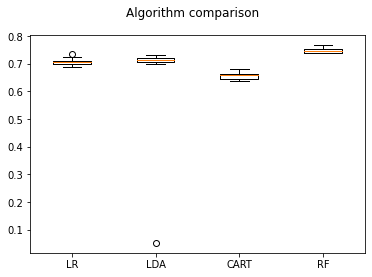

In [55]:
# Algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [56]:
#Grid Search Forest Classifier
from sklearn.model_selection import GridSearchCV
parameter_grid = {'n_estimators': [100, 200, 300, 400, 500, 600]}
grid = GridSearchCV(RandomForestClassifier(),parameter_grid,verbose=3)
grid.fit(x_train_prep, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ..................n_estimators=100;, score=0.771 total time=  57.9s
[CV 2/5] END ..................n_estimators=100;, score=0.768 total time=  58.4s
[CV 3/5] END ..................n_estimators=100;, score=0.774 total time=  58.3s
[CV 4/5] END ..................n_estimators=100;, score=0.771 total time=  57.2s
[CV 5/5] END ..................n_estimators=100;, score=0.772 total time=  57.5s
[CV 1/5] END ..................n_estimators=200;, score=0.773 total time= 1.9min
[CV 2/5] END ..................n_estimators=200;, score=0.772 total time= 1.9min
[CV 3/5] END ..................n_estimators=200;, score=0.785 total time= 1.9min
[CV 4/5] END ..................n_estimators=200;, score=0.769 total time= 1.9min
[CV 5/5] END ..................n_estimators=200;, score=0.785 total time= 1.9min
[CV 1/5] END ..................n_estimators=300;, score=0.782 total time= 2.8min
[CV 2/5] END ..................n_estimators=300;,

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [100, 200, 300, 400, 500, 600]},
             verbose=3)

In [57]:
grid.best_estimator_

RandomForestClassifier(n_estimators=600)

In [37]:
# Model 2: Random Forest Classifier (image features)
Model_2  = RandomForestClassifier(n_estimators=600)
Model_2.fit(x_train_prep, y_train)
predictions_2 = Model_2.predict(x_test_prep)
predictions_proba_2 = Model_2.predict_proba(x_test_prep)

print('Percentage correct: ', 100*np.sum(predictions_2 == y_test)/len(y_test))
F1_2 = f1_score(y_test, predictions_2,average='weighted')
print('F1 Score: ',F1_2)

Percentage correct:  77.02970297029702
F1 Score:  0.7435837990581983


Voting system: combining Models 1 and 2

In [38]:
def voting_model(probas_model1,probas_model2,weight1,weight2):
    '''
    Explanation.

            Parameters:
                    probas_model1 (list): List of probabilities* given by model 1. 
                    probas_model2 (list): List of probabilities* given by model 2.
                    *This is a list of lists. For each card, there is a list inside with the probabilities of that card belonging to each of the 6 colors. 
                    (ex: [[0.1,0.2,0.1,0.1,0.3,0.2],[0.1,0.1,0.1,0.1,0.1,0.5],...])
                    
                    weight1 (float): Weight of model 1.
                    weight2 (float): Weight of model 2.

            Returns:
                    probas_combined (list): List of combined probabilities given by the voting system.
    '''  
    probas_combined = np.zeros(shape=probas_model1.shape, dtype=float)
    for idx,proba in enumerate(zip(probas_model1,probas_model2)):
        for i,(p1,p2) in enumerate(zip(probas_model1[idx],probas_model2[idx])):
            combined = p1*weight1+p2*weight2
            probas_combined[idx,i] = combined
        
    return probas_combined

In [39]:
# FUNCTION: given the list of probabilities for the combined model, we check what is the highest probability and which color it corresponds to.
# The output will be, for each card, the prediction of the combined model
def get_prediction(labels,probas_combined):
    '''
    Explanation.

            Parameters:
                    labels (list): List of strings with the unique color names, in the same order they appear in the probability lists.
                    probas_combined (list): List of combined probabilities given by the voting system.

            Returns:
                    combined_result (list):  List of strings with the color guesses* made by the voting system (ex: ['Red','Blue',...]). 
                    *This corresponds, for each card, to the color with the highest probability as guessed by the combined model. 
    '''  
    combined_result = []
    for proba in probas_combined:
        prediction = labels[np.where(proba == np.amax(proba))[0][0]]
        combined_result.append(prediction)
    return combined_result

Maximum Accuracy: 89.52970297029702 | F1-Score: 0.8948279357070528. 
Weight 1 = 0.3, weigth 2 = 0.7.


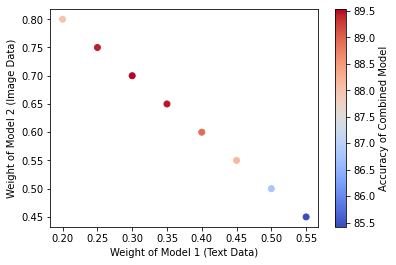

In [65]:
def weight_opt(weight1_list,weight2_list,labels,probas_model1,probas_model2):
    '''
    Draws a plot of the different accuracies obtained with different weights 1 and 2 for each model.
    Prints the optimal values for weight 1 and 2 and the corresponding maximum accuracy/F1 score found.

            Parameters:
                    weight1_list (list): Weight values to be tested for weight 1.
                    weight2_list (list): Weight values to be tested for weight 2.
                    labels (list): List of strings with the unique color names, in the same order they appear in the probability lists.
                    probas_model1 (list): List of probabilities* given by model 1. 
                    probas_model2 (list): List of probabilities* given by model 2.
                    *This is a list of lists. For each card, there is a list inside with the probabilities of that card belonging to each of the 6 colors. 
                    (ex: [[0.1,0.2,0.1,0.1,0.3,0.2],[0.1,0.1,0.1,0.1,0.1,0.5],...])
    
            Returns: (w1,w2) (tuple): Tuple with the optimal weights 1 and 2.
    '''  
    accuracy_list = []
    f1_list = []
    
    def voting_model(probas_model1,probas_model2,weight1,weight2):
        '''
        Explanation.

                Parameters:
                        probas_model1 (list): List of lists with the probabilities* given by model 1. 
                        probas_model2 (list): List of lists with probabilities* given by model 2.
                        weight1 (float): Weight of model 1.
                        weight2 (float): Weight of model 2.

                Returns:
                        probas_combined (list): List of lists with the combined probabilities given by the voting system.
        '''  
        probas_combined = np.zeros(shape=probas_model1.shape, dtype=float)
        for idx,proba in enumerate(zip(probas_model1,probas_model2)):
            for i,(p1,p2) in enumerate(zip(probas_model1[idx],probas_model2[idx])):
                combined = p1*weight1+p2*weight2
                probas_combined[idx,i] = combined
            
        return probas_combined

    def get_prediction(labels,probas_combined):
        '''
        Explanation.

                Parameters:
                        labels (list): List of strings with the unique color names, in the same order they appear in the probability lists.
                        probas_combined (list): List of lists with the combined probabilities given by the voting system.

                Returns:
                        combined_result (list):  List of strings with the color guesses* made by the voting system (ex: ['Red','Blue',...]). 
                        *This corresponds, for each card, to the color with the highest probability as guessed by the combined model. 
        '''  
        combined_result = []
        for proba in probas_combined:
            prediction = labels[np.where(proba == np.amax(proba))[0][0]]
            combined_result.append(prediction)
        return combined_result


    for idx,(w1,w2) in enumerate(zip(weight1_list,weight2_list)):
        probas_combined = voting_model(probas_model1,probas_model2,w1,w2)
        predict_result = get_prediction(labels,probas_combined)
        accuracy = 100*np.sum(predict_result == y_test)/len(y_test)
        f1 = f1_score(y_test, predict_result,average='weighted')
        accuracy_list.append(accuracy)
        f1_list.append(f1)

    # Dataframe with the results
    df_wopt =pd.DataFrame(data={'W1':weight1_list,'W2':weight2_list,'Accuracy':accuracy_list,'F1 Score':f1_list})

    # Print best result
    condition = df_wopt[df_wopt['Accuracy']==df_wopt['Accuracy'].max()]
    print('Maximum Accuracy: '+str(condition['Accuracy'].item())+' | F1-Score: '+str(condition['F1 Score'].item())+'. \nWeight 1 = '+str(condition['W1'].item())+', weigth 2 = '+str(condition['W2'].item())+'.')
    
    # Plot the results
    plt.scatter(df_wopt['W1'],df_wopt['W2'],c = df_wopt['Accuracy'], cmap='coolwarm')
    plt.colorbar(label='Accuracy of Combined Model')
    plt.xlabel('Weight of Model 1 (Text Data)')
    plt.ylabel('Weight of Model 2 (Image Data)')

    return (condition['W1'].item(),condition['W2'].item())

# Function call
labels = np.unique(list(y_test))
(w1, w2) = weight_opt([0.55,0.5,0.45,0.40,0.35,0.30,0.25,0.2],[0.45,0.5,0.55,0.60,0.65,0.70,0.75,0.8],labels,predictions_proba_1,predictions_proba_2)

In [67]:
# So the combined model then becomes
probas_combined = voting_model(predictions_proba_1,predictions_proba_2,w1,w2)
predict_result = get_prediction(labels,probas_combined)
print('Percentage correct: ', 100*np.sum(predict_result == y_test)/len(y_test))

Percentage correct:  89.52970297029702


In [69]:
#Confusion matrix
label_list = list(y_test)

df_matrix = pd.DataFrame(
    np.c_[label_list, predict_result], 
    columns=['true_label', 'prediction']
)

label_names = np.unique(label_list)
cmx = confusion_matrix(label_list, predict_result, labels=label_names)
df_matrix = pd.DataFrame(cmx, columns=label_names, index=label_names)
df_matrix.columns.name = 'prediction'
df_matrix.index.name = 'label'
df_matrix

prediction,Black,Blue,Colorless,Green,Red,White
label,,,,,,
Black,608,29,12,25,32,13
Blue,9,719,7,7,2,5
Colorless,7,20,367,15,9,19
Green,2,23,2,653,5,7
Red,11,19,4,17,632,16
White,16,47,15,25,16,625


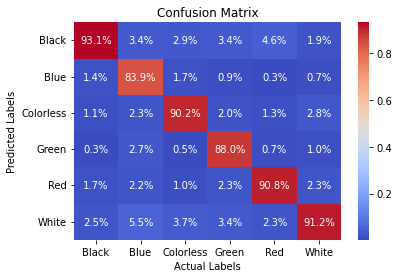

In [70]:
ax = sns.heatmap(df_matrix/np.sum(df_matrix),annot=True,cmap="coolwarm", fmt='.1%')
ax.set(title='Confusion Matrix',xlabel='Actual Labels',ylabel='Predicted Labels');

In [68]:
print(classification_report(y_test,predict_result))

              precision    recall  f1-score   support

       Black       0.93      0.84      0.89       719
        Blue       0.85      0.96      0.90       749
   Colorless       0.91      0.84      0.87       437
       Green       0.88      0.95      0.91       692
         Red       0.90      0.90      0.90       699
       White       0.92      0.85      0.88       744

    accuracy                           0.90      4040
   macro avg       0.90      0.89      0.89      4040
weighted avg       0.90      0.90      0.89      4040



Exploring the predictions and overall results

In [70]:
def get_probas_discriminated(predictions_proba,labels):
    '''
    Get the prediction results of a classification model in the 'X.XXX% Color1 | X.XXX% Color2 | ...' format.

            Parameters:
                    labels (list): List of strings with the unique color names, in the same order they appear in the probability lists.
                    predictions_proba (list): List of lists with the probabilities given by a classification model.

            Returns:
                    predict_list (tuple): Tuple (X,Y) where the X's are lists of strings with the discriminated colors and respective probabilities
                                            and Y's are the ultimate prediction made by the model for that specific card (ex: 'Red').
    '''  
    predict_list = []
    
    for idx,l in enumerate(predictions_proba):
        proba = list(predictions_proba[idx])
        msg = ''
        for r in range(0,len(proba)):
            msg_new = str(round(predictions_proba[idx][r],3)) + '% ' + labels[r] + ' | ' 
            msg = msg + msg_new
            guess = labels[np.where(proba == np.amax(proba))[0][0]]
        predict_list.append((msg[:-3],guess))
    
    return predict_list

# Call function
idx_model1 = get_probas_discriminated(predictions_proba_1,labels)
idx_model2 = get_probas_discriminated(predictions_proba_2,labels)
idx_modelv = get_probas_discriminated(probas_combined,labels)

In [73]:
idx_modelv[0]

('0.095% Black | 0.068% Blue | 0.048% Colorless | 0.145% Green | 0.521% Red | 0.123% White',
 'Red')

In [71]:
# Create a dataframe with all the results (discriminated and final prediction) for each model

# Create 1 dataframe per model
df_model1 = pd.DataFrame(idx_model1)
df_model2 = pd.DataFrame(idx_model2)
df_modelv = pd.DataFrame(idx_modelv)

# Rename columns
model1_cols = {0:'Model 1 (%)',1:'Model 1 (Guess)'}
model2_cols = {0:'Model 2 (%)',1:'Model 2 (Guess)'}
modelv_cols = {0:'Combined Model (%)',1:'Combined Model (Guess)'}
df_model1.rename(columns=model1_cols,inplace=True)
df_model2.rename(columns=model2_cols,inplace=True)
df_modelv.rename(columns=modelv_cols,inplace=True)

# Join the 3 dataframes
df_guesses = df_model1.join(df_model2).join(df_modelv)

In [75]:
df_guesses.head()

,Model 1 (%),Model 1 (Guess),Model 2 (%),Model 2 (Guess),Combined Model (%),Combined Model (Guess)
0,0.006% Black | 0.0% Blue | 0.001% Colorless | ...,Red,0.133% Black | 0.097% Blue | 0.069% Colorless ...,Red,0.095% Black | 0.068% Blue | 0.048% Colorless ...,Red
1,0.018% Black | 0.065% Blue | 0.098% Colorless ...,Green,0.042% Black | 0.082% Blue | 0.117% Colorless ...,White,0.035% Black | 0.077% Blue | 0.111% Colorless ...,White
2,0.014% Black | 0.0% Blue | 0.0% Colorless | 0....,Green,0.127% Black | 0.132% Blue | 0.042% Colorless ...,Green,0.093% Black | 0.092% Blue | 0.029% Colorless ...,Green
3,0.002% Black | 0.971% Blue | 0.001% Colorless ...,Blue,0.103% Black | 0.578% Blue | 0.06% Colorless |...,Blue,0.073% Black | 0.696% Blue | 0.042% Colorless ...,Blue
4,0.096% Black | 0.029% Blue | 0.001% Colorless ...,Green,0.06% Black | 0.236% Blue | 0.083% Colorless |...,White,0.071% Black | 0.174% Blue | 0.059% Colorless ...,White


In [72]:
# Get the correct labels from the dataframes with the test data, by joining x_test and y_test
df_results = x_test.copy()
df_results['Labels'] = y_test
df_results.reset_index(inplace=True)

In [77]:
df_results.head()

,index,Name,URL,name,text,categorical,ImageDataCrop,Labels
0,15134,Wrecking Ogre,https://c1.scryfall.com/file/scryfall-cards/la...,wrecking ogre,double strikebloodrush — discard wrecking ogr...,ogre warrior creature bloodrush double strike ...,"[[[122, 36, 26], [136, 45, 32], [95, 75, 71], ...",Red
1,2084,Hundred-Handed One,https://c1.scryfall.com/file/scryfall-cards/la...,hundred-handed one,vigilance monstrosity 3 creature monstrous put...,giant creature monstrosity vigilance 3 5 4,"[[[124, 120, 113], [136, 132, 132], [105, 94, ...",White
2,1994,Tel-Jilad Lifebreather,https://c1.scryfall.com/file/scryfall-cards/la...,tel-jilad lifebreather,sacrifice forest regenerate target creature,troll shaman creature 3 2 5,"[[[43, 76, 46], [49, 44, 35], [113, 106, 97], ...",Green
3,15182,Giant Crab,https://c1.scryfall.com/file/scryfall-cards/la...,giant crab,giant crab gains shroud end turn target spell...,crab creature 3 3 5,"[[[48, 85, 131], [50, 64, 115], [54, 90, 124],...",Blue
4,5116,Fortifying Provisions,https://c1.scryfall.com/file/scryfall-cards/la...,fortifying provisions,creatures control get +0/+1fortifying provisio...,enchantment 3,"[[[190, 181, 190], [103, 92, 103], [183, 182, ...",White


In [78]:
len(df_results)

4040

In [73]:
# Join the predictions with the results, based on the index
df_results = df_results.join(df_guesses)
# Drop columns we dont need
df_results.drop(['index','name','text','categorical','ImageDataCrop'], axis=1,inplace=True)

In [83]:
df_results.head()

,Name,URL,Labels,Model 1 (%),Model 1 (Guess),Model 2 (%),Model 2 (Guess),Combined Model (%),Combined Model (Guess)
0,Wrecking Ogre,https://c1.scryfall.com/file/scryfall-cards/la...,Red,0.006% Black | 0.0% Blue | 0.001% Colorless | ...,Red,0.133% Black | 0.097% Blue | 0.069% Colorless ...,Red,0.095% Black | 0.068% Blue | 0.048% Colorless ...,Red
1,Hundred-Handed One,https://c1.scryfall.com/file/scryfall-cards/la...,White,0.018% Black | 0.065% Blue | 0.098% Colorless ...,Green,0.042% Black | 0.082% Blue | 0.117% Colorless ...,White,0.035% Black | 0.077% Blue | 0.111% Colorless ...,White
2,Tel-Jilad Lifebreather,https://c1.scryfall.com/file/scryfall-cards/la...,Green,0.014% Black | 0.0% Blue | 0.0% Colorless | 0....,Green,0.127% Black | 0.132% Blue | 0.042% Colorless ...,Green,0.093% Black | 0.092% Blue | 0.029% Colorless ...,Green
3,Giant Crab,https://c1.scryfall.com/file/scryfall-cards/la...,Blue,0.002% Black | 0.971% Blue | 0.001% Colorless ...,Blue,0.103% Black | 0.578% Blue | 0.06% Colorless |...,Blue,0.073% Black | 0.696% Blue | 0.042% Colorless ...,Blue
4,Fortifying Provisions,https://c1.scryfall.com/file/scryfall-cards/la...,White,0.096% Black | 0.029% Blue | 0.001% Colorless ...,Green,0.06% Black | 0.236% Blue | 0.083% Colorless |...,White,0.071% Black | 0.174% Blue | 0.059% Colorless ...,White


In [87]:
def evaluation(row,col1,col2):
    '''
    Determine wether a guess is correct by comparing two columns of a dataframe (if Label=Guess, then Correct).

            Parameters:
                    row (pandas series): Variable of the lambda function. 
                    In this example, it is the content of a pandas dataframe row because axis=1 was specified in the lambda function.
                    col1 (str): Name of the dataframe column to be compared with col2.
                    col2 (str): Name of the dataframe column to be compared with col1.
    '''  
    
    if row[col1] == row[col2]:
        return 'Correct'
    else:
        return 'Incorrect'

# Create a column with the evaluation result for each Model
df_results['Evaluation'] = df_results.apply (lambda row: evaluation(row,'Labels','Combined Model (Guess)'), axis=1)
df_results['Model 1'] = df_results.apply (lambda row: evaluation(row,'Labels','Model 1 (Guess)'), axis=1)
df_results['Model 2'] = df_results.apply (lambda row: evaluation(row,'Labels','Model 2 (Guess)'), axis=1)

In [88]:
df_results.head()

,Name,URL,Labels,Model 1 (%),Model 1 (Guess),Model 2 (%),Model 2 (Guess),Combined Model (%),Combined Model (Guess),Evaluation,Model 1,Model 2
0,Wrecking Ogre,https://c1.scryfall.com/file/scryfall-cards/la...,Red,0.006% Black | 0.0% Blue | 0.001% Colorless | ...,Red,0.158% Black | 0.05% Blue | 0.076% Colorless |...,Red,0.113% Black | 0.035% Blue | 0.053% Colorless ...,Red,Correct,Correct,Correct
1,Hundred-Handed One,https://c1.scryfall.com/file/scryfall-cards/la...,White,0.018% Black | 0.065% Blue | 0.098% Colorless ...,Green,0.053% Black | 0.072% Blue | 0.154% Colorless ...,White,0.043% Black | 0.07% Blue | 0.137% Colorless |...,White,Correct,Incorrect,Correct
2,Tel-Jilad Lifebreather,https://c1.scryfall.com/file/scryfall-cards/la...,Green,0.014% Black | 0.0% Blue | 0.0% Colorless | 0....,Green,0.112% Black | 0.138% Blue | 0.042% Colorless ...,Green,0.082% Black | 0.097% Blue | 0.029% Colorless ...,Green,Correct,Correct,Correct
3,Giant Crab,https://c1.scryfall.com/file/scryfall-cards/la...,Blue,0.002% Black | 0.971% Blue | 0.001% Colorless ...,Blue,0.077% Black | 0.635% Blue | 0.057% Colorless ...,Blue,0.054% Black | 0.736% Blue | 0.04% Colorless |...,Blue,Correct,Correct,Correct
4,Fortifying Provisions,https://c1.scryfall.com/file/scryfall-cards/la...,White,0.096% Black | 0.029% Blue | 0.001% Colorless ...,Green,0.07% Black | 0.21% Blue | 0.077% Colorless | ...,White,0.078% Black | 0.156% Blue | 0.054% Colorless ...,White,Correct,Incorrect,Correct


In [87]:
df_results.groupby(['Evaluation','Model 1','Model 2']).size()

Evaluation  Model 1    Model 2  
Correct     Correct    Correct      2348
                       Incorrect     638
            Incorrect  Correct       603
                       Incorrect      15
Incorrect   Correct    Incorrect     114
            Incorrect  Correct       140
                       Incorrect     182
dtype: int64

In [103]:
# Create a dataframe with all the possible guess scenarios and their %s
df_evaluation = df_results[['Model 1','Model 2','Evaluation']]
df_evaluation = df_evaluation.groupby(['Model 1','Model 2','Evaluation']).size().reset_index().rename(columns={0:'Count'})

# Add the impossible scenario (Both Models correct, combined model incorrect)
new = pd.DataFrame([['Correct','Correct','Incorrect',0]], columns=['Model 1','Model 2','Evaluation','Count'])
df_evaluation = pd.concat([new, df_evaluation]).reset_index().drop(["index"], axis=1)

# Add % to the dataframe
df_evaluation['Percentage'] = df_evaluation['Count'].apply(lambda x: round((x/len(df_results)*100),2))

In [108]:
df_evaluation

,Model 1,Model 2,Evaluation,Count,Percentage
0,Correct,Correct,Incorrect,0,0.00
1,Correct,Correct,Correct,2348,58.12
2,Correct,Incorrect,Correct,638,15.79
3,Correct,Incorrect,Incorrect,114,2.82
4,Incorrect,Correct,Correct,603,14.93
5,Incorrect,Correct,Incorrect,140,3.47
6,Incorrect,Incorrect,Correct,15,0.37
7,Incorrect,Incorrect,Incorrect,182,4.50


Examples for each scenario

In [98]:
# 1) Both Models incorrect, combined model correct
m1I_m2I_mcC = (df_results['Evaluation']=='Correct') & (df_results['Model 1']=='Incorrect') & (df_results['Model 2']=='Incorrect')
df_results[m1I_m2I_mcC].head(1)

,Name,URL,Labels,Model 1 (%),Model 1 (Guess),Model 2 (%),Model 2 (Guess),Combined Model (%),Combined Model (Guess),Evaluation,Model 1,Model 2
622,Undercity's Embrace,https://c1.scryfall.com/file/scryfall-cards/la...,Black,0.337% Black | 0.009% Blue | 0.002% Colorless ...,White,0.358% Black | 0.433% Blue | 0.037% Colorless ...,Blue,0.352% Black | 0.306% Blue | 0.026% Colorless ...,Black,Correct,Incorrect,Incorrect


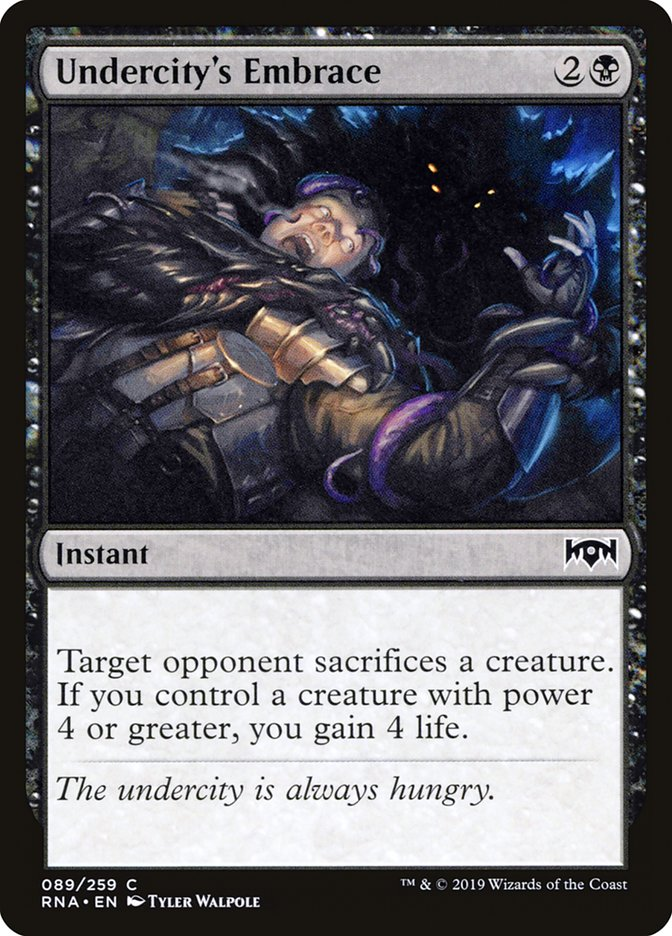

In [99]:
display.Image(list(df_results[m1I_m2I_mcC]['URL'])[0], width=200)

In [100]:
# 2) Both Models correct, combined model incorrect - Impossible Scenario
m1C_m2C_mcI = (df_results['Evaluation']=='Incorrect') & (df_results['Model 1']=='Correct') & (df_results['Model 2']=='Correct')
df_results[m1C_m2C_mcI].head(1)

,Name,URL,Labels,Model 1 (%),Model 1 (Guess),Model 2 (%),Model 2 (Guess),Combined Model (%),Combined Model (Guess),Evaluation,Model 1,Model 2


In [111]:
# 3) M1 correct, M2 incorrect, combined model correct 
m1C_m2I_mcC = (df_results['Evaluation']=='Correct') & (df_results['Model 1']=='Correct') & (df_results['Model 2']=='Incorrect')
df_results[m1C_m2I_mcC].head(1)

,Name,URL,Labels,Model 1 (%),Model 1 (Guess),Model 2 (%),Model 2 (Guess),Combined Model (%),Combined Model (Guess),Evaluation,Model 1,Model 2
12,Agent of Shauku,https://c1.scryfall.com/file/scryfall-cards/la...,Black,0.839% Black | 0.009% Blue | 0.004% Colorless ...,Black,0.285% Black | 0.103% Blue | 0.097% Colorless ...,Green,0.451% Black | 0.075% Blue | 0.069% Colorless ...,Black,Correct,Correct,Incorrect


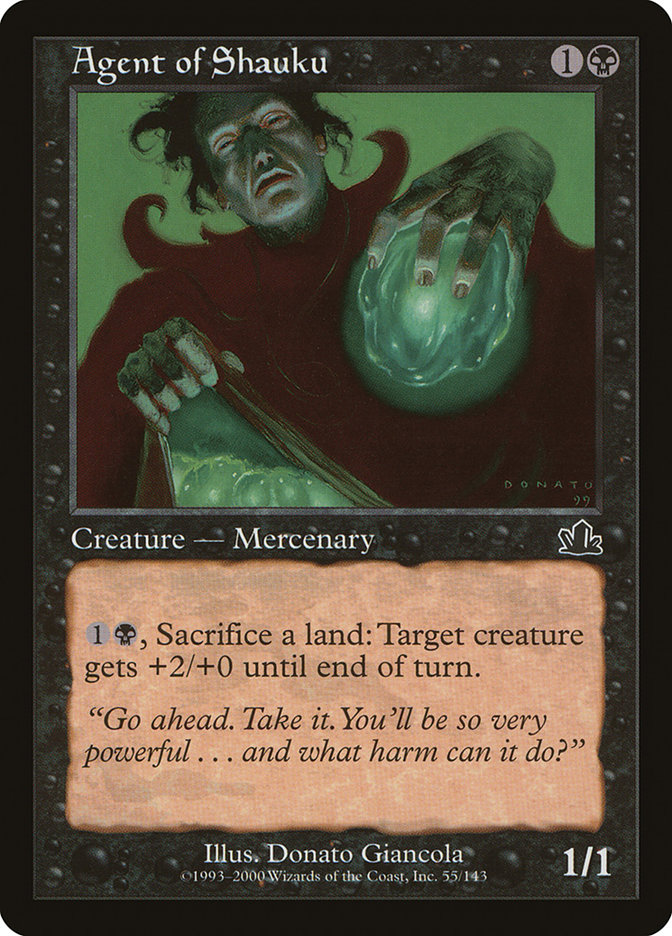

In [110]:
display.Image(list(df_results[m1C_m2I_mcC]['URL'])[0], width=200)

In [113]:
# 4) M1 correct, M2 incorrect, combined model incorrect 
m1C_m2I_mcI = (df_results['Evaluation']=='Incorrect') & (df_results['Model 1']=='Correct') & (df_results['Model 2']=='Incorrect')
df_results[m1C_m2I_mcI].head(1)

,Name,URL,Labels,Model 1 (%),Model 1 (Guess),Model 2 (%),Model 2 (Guess),Combined Model (%),Combined Model (Guess),Evaluation,Model 1,Model 2
9,Ulamog's Reclaimer,https://c1.scryfall.com/file/scryfall-cards/la...,Blue,0.384% Black | 0.406% Blue | 0.035% Colorless ...,Blue,0.117% Black | 0.101% Blue | 0.172% Colorless ...,Red,0.197% Black | 0.193% Blue | 0.131% Colorless ...,Red,Incorrect,Correct,Incorrect


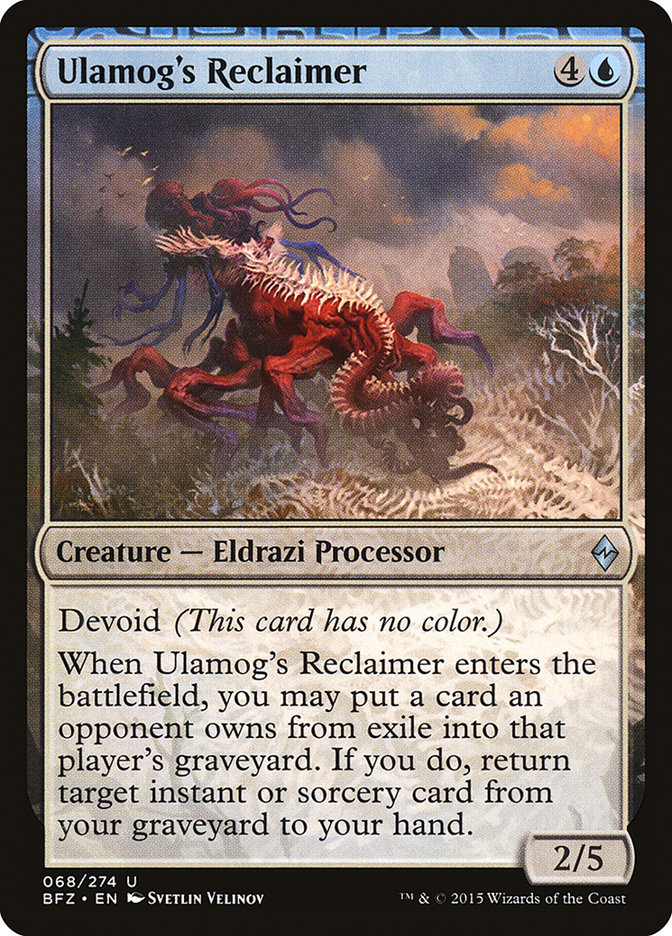

In [114]:
display.Image(list(df_results[m1C_m2I_mcI]['URL'])[0], width=200)

In [115]:
# 5) M1 incorrect, M2 correct, combined model correct 
m1I_m2C_mcC = (df_results['Evaluation']=='Correct') & (df_results['Model 1']=='Incorrect') & (df_results['Model 2']=='Correct')
df_results[m1I_m2C_mcC].head(1)

,Name,URL,Labels,Model 1 (%),Model 1 (Guess),Model 2 (%),Model 2 (Guess),Combined Model (%),Combined Model (Guess),Evaluation,Model 1,Model 2
1,Hundred-Handed One,https://c1.scryfall.com/file/scryfall-cards/la...,White,0.018% Black | 0.065% Blue | 0.098% Colorless ...,Green,0.042% Black | 0.082% Blue | 0.117% Colorless ...,White,0.035% Black | 0.077% Blue | 0.111% Colorless ...,White,Correct,Incorrect,Correct


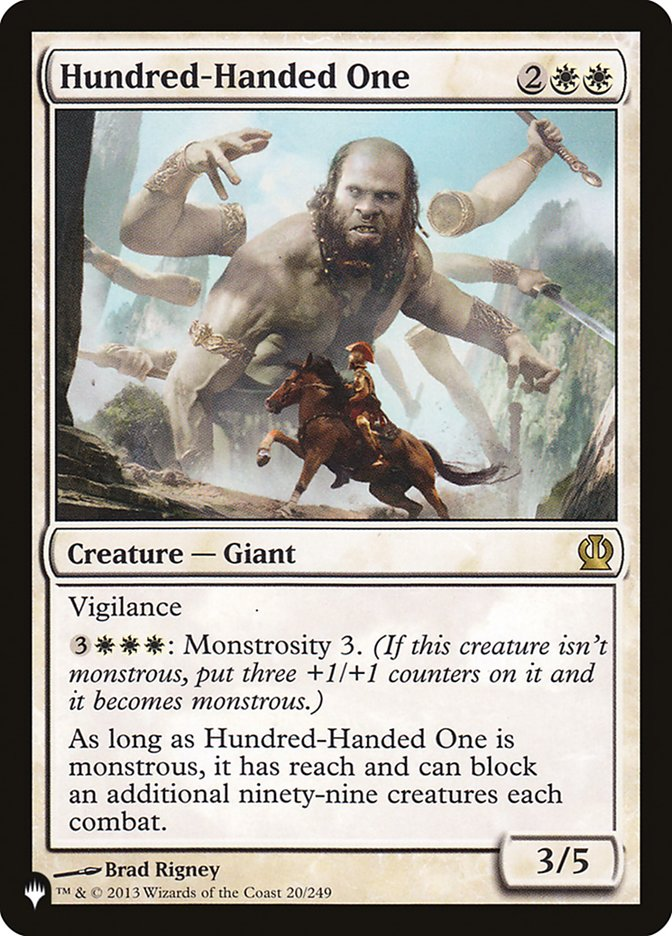

In [116]:
display.Image(list(df_results[m1I_m2C_mcC]['URL'])[0], width=200)

In [117]:
# 6) M1 incorrect, M2 correct, combined model incorrect 
m1I_m2C_mcI = (df_results['Evaluation']=='Incorrect') & (df_results['Model 1']=='Incorrect') & (df_results['Model 2']=='Correct')
df_results[m1I_m2C_mcI].head(1)

,Name,URL,Labels,Model 1 (%),Model 1 (Guess),Model 2 (%),Model 2 (Guess),Combined Model (%),Combined Model (Guess),Evaluation,Model 1,Model 2
96,Gauntlet of Might,https://c1.scryfall.com/file/scryfall-cards/la...,Red,0.003% Black | 0.007% Blue | 0.721% Colorless ...,Colorless,0.116% Black | 0.197% Blue | 0.184% Colorless ...,Red,0.082% Black | 0.14% Blue | 0.345% Colorless |...,Colorless,Incorrect,Incorrect,Correct


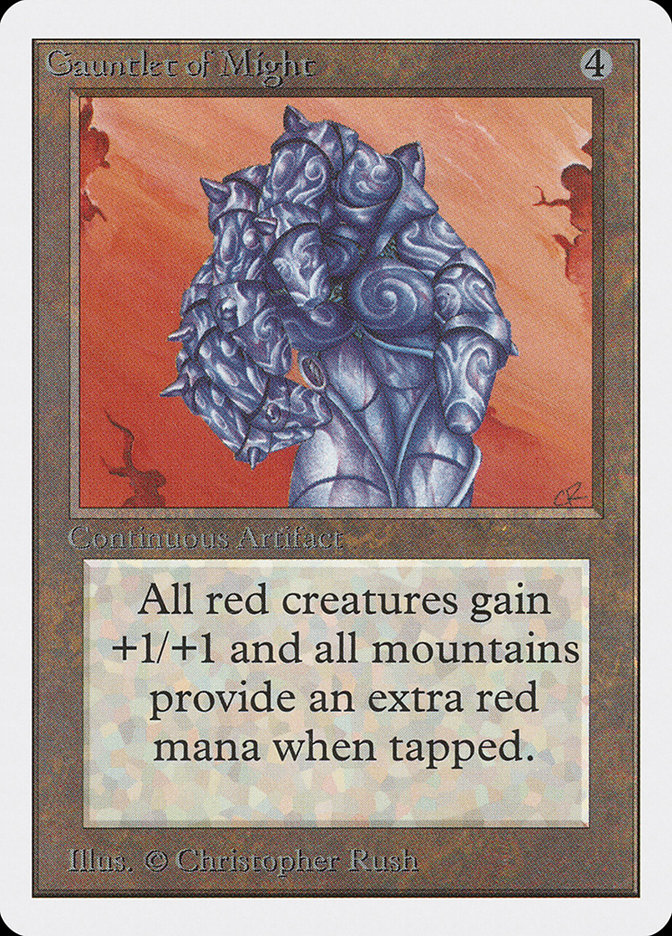

In [118]:
display.Image(list(df_results[m1I_m2C_mcI]['URL'])[0], width=200)

In [119]:
# 7) M1 correct, M2 correct, combined model correct 
m1C_m2C_mcC = (df_results['Evaluation']=='Correct') & (df_results['Model 1']=='Correct') & (df_results['Model 2']=='Correct')
df_results[m1C_m2C_mcC].head(1)

,Name,URL,Labels,Model 1 (%),Model 1 (Guess),Model 2 (%),Model 2 (Guess),Combined Model (%),Combined Model (Guess),Evaluation,Model 1,Model 2
0,Wrecking Ogre,https://c1.scryfall.com/file/scryfall-cards/la...,Red,0.006% Black | 0.0% Blue | 0.001% Colorless | ...,Red,0.133% Black | 0.097% Blue | 0.069% Colorless ...,Red,0.095% Black | 0.068% Blue | 0.048% Colorless ...,Red,Correct,Correct,Correct


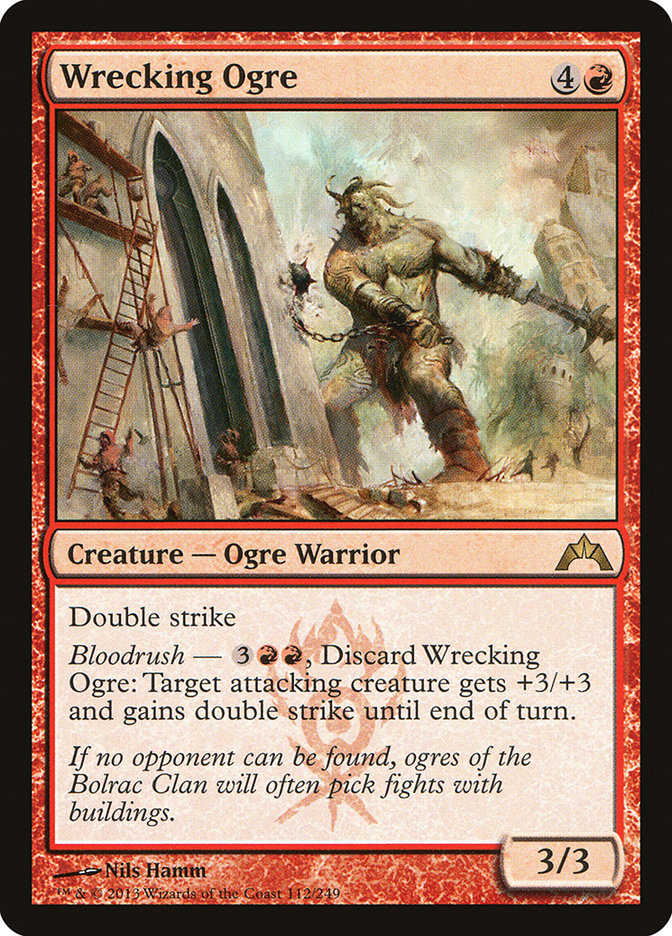

In [120]:
display.Image(list(df_results[m1C_m2C_mcC]['URL'])[0], width=200)

In [121]:
# 8) M1 incorrect, M2 incorrect, combined model incorrect 
m1I_m2I_mcI = (df_results['Evaluation']=='Incorrect') & (df_results['Model 1']=='Incorrect') & (df_results['Model 2']=='Incorrect')
df_results[m1I_m2I_mcI].head(1)

,Name,URL,Labels,Model 1 (%),Model 1 (Guess),Model 2 (%),Model 2 (Guess),Combined Model (%),Combined Model (Guess),Evaluation,Model 1,Model 2
48,Blasted Landscape,https://c1.scryfall.com/file/scryfall-cards/la...,Colorless,0.1% Black | 0.355% Blue | 0.134% Colorless | ...,Blue,0.255% Black | 0.256% Blue | 0.125% Colorless ...,Blue,0.208% Black | 0.286% Blue | 0.128% Colorless ...,Blue,Incorrect,Incorrect,Incorrect


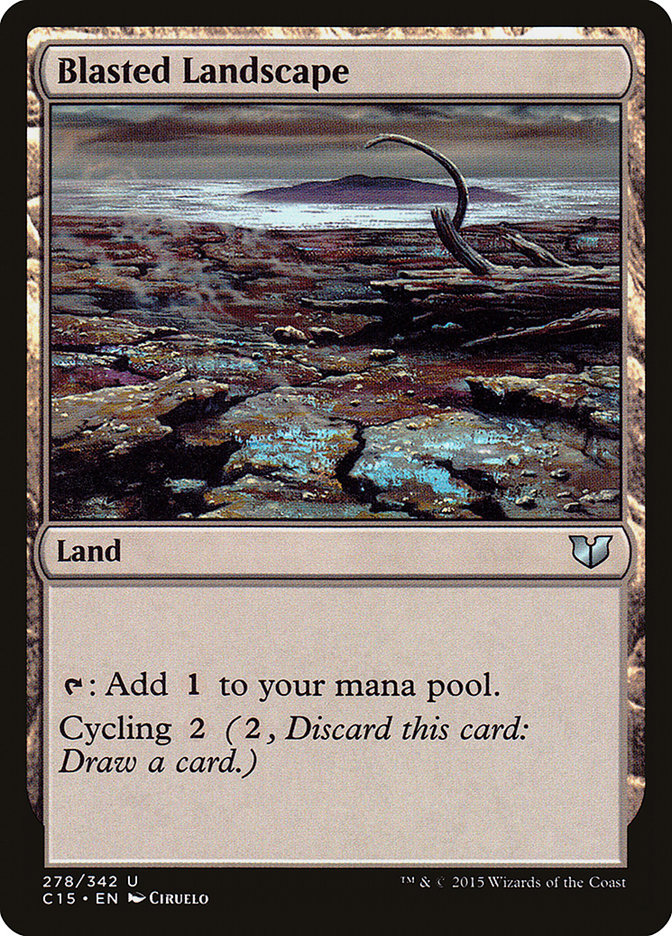

In [122]:
display.Image(list(df_results[m1I_m2I_mcI]['URL'])[0], width=200)